<a href="https://colab.research.google.com/github/newbee1905/TrafficFlowPrediction/blob/master/TrafficFlowPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive and Setting data Location

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_folder = '/content/drive/MyDrive/TrafficFlowPrediction'

In [ ]:
data_file = f'{data_folder}/Scats Data October 2006.xls'

# Setting up the Environment

In [ ]:
!pip install pandas numpy scikit-learn==1.3.1 keras==2.13.1 tensorflow==2.13.0 matplotlib prophet

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import sys
import warnings
import math
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from typing import Callable

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM, GRU, Conv1D
from prophet import Prophet
from keras.models import Sequential, load_model
from prophet.serialize import model_to_json, model_from_json


from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from multiprocessing import cpu_count, Pool

from keras import backend as K

from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics

import matplotlib as mpl
import matplotlib.pyplot as plt

# Data Processing


#### Ultility functions

In [ ]:
def scaler(min, max):
	def _scaler(x):
		return (x - min) / (max - min)
	return _scaler

def rescaler(min, max):
	def _rescaler(x):
		return x * (max - min) + min
	return _rescaler

def read_excel_data(data: str) -> pd.DataFrame:
    """
    Read data from an Excel file.

    Args:
        data (str): Name of the Excel data file.

    Returns:
        pd.DataFrame: The data read from the Excel file.
    """
    df = pd.read_excel(data, sheet_name="Data", header=[1])
    return df


#### Process Data funciton for SAEs, LSTM, GRU and CNN

In [ ]:
def process_data(df: pd.DataFrame, lags: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, callable, callable]:
    """
    Process Data
    Reshape and split data into train and test data.

    Parameters:
        df (df.DataFram): dataframe of the data
        lags (int): time lag

    Returns:
        X_train (np.ndarray)
        y_train (np.ndarray)
        X_test (np.ndarray)
        y_test (np.ndarray)
        flow_scaler (func)
    """

    flow_group = np.char.mod("V%02d", np.arange(0, 96))
    grouped = df.groupby(['NB_LATITUDE', 'NB_LONGITUDE'])[flow_group].apply(lambda x: x.values.tolist())

    flow_data = grouped.values
    flow_max = np.array(flow_data.max()).max()
    flow_min = np.array(flow_data.min()).min()

    flow_scaler = scaler(flow_min, flow_max)
    flow_rescaler = rescaler(flow_min, flow_max)

    latlong_data = np.array(grouped.index.to_list())
    latlong_scaler = MinMaxScaler(feature_range=(0, 1)).fit(latlong_data.reshape(-1, 1))
    latlong_data = latlong_scaler.transform(latlong_data.reshape(-1, 1)).reshape(-1, 2)

    train = []

    i = 0
    for flow in grouped.values:
        flow = np.array(flow, dtype=float).flatten()
        flow = np.vectorize(flow_scaler)(flow)
        indices = np.arange(lags, len(flow))
        offset = np.arange(-lags, 1)
        flow = flow[indices[:, np.newaxis] + offset]
        latlong = np.tile(latlong_data[i], (len(flow), 1))
        combined_arr = np.hstack((latlong, flow))
        train.extend(combined_arr)
        i += 1

    train = np.array(train)

    X = train[:, :-1]
    y = train[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=.75, shuffle=True)

    return X_train, y_train, X_test, y_test, flow_scaler, flow_rescaler, latlong_scaler


#### Process Data functions for Prophet model

In [ ]:
def process_data_prophet(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Process Data for Prophet Model
    Reshape and split data into train and test data for prophet model

    Parameters:
        df (df.DataFram): dataframe of the data

    Returns:
        train (np.ndarray)
        test (np.ndarray)
    """
    first_velo_col_pos = df.columns.get_loc("V00")
    flow_data = df.to_numpy()[:, first_velo_col_pos:]

    flatten_flow_data = flow_data.reshape(-1, 1)

    lat_data = df['NB_LATITUDE'].to_numpy().reshape(-1, 1)
    long_data = df['NB_LONGITUDE'].to_numpy().reshape(-1, 1)

    latlong_data = np.concatenate((lat_data, long_data), axis=1)

    date_data = df['Date'].to_numpy().reshape(-1, 1)

    num_time_steps = 96

    # 15 minutes per velo
    time_values = np.arange(-1, num_time_steps - 1) * 15 * 60 * 1000 * 1000 * 1000

    expanded_latlong = np.repeat(latlong_data, num_time_steps, axis=0).reshape(-1, 2)

    expanded_date = np.repeat(date_data, num_time_steps, axis=0).reshape(-1, num_time_steps)
    expanded_date = pd.to_datetime((expanded_date + time_values).reshape(-1, 1))

    train = np.hstack((expanded_latlong, expanded_date, flatten_flow_data))

    train_size = int(len(train) * 0.75 // num_time_steps * num_time_steps)
    test = train[train_size:, :]
    train = train[:train_size, :]

    return train, test

# Model

## LSTM

In [ ]:
def get_lstm(units):
    """LSTM(Long Short-Term Memory)
    Build LSTM Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(LSTM(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(LSTM(units[2], return_sequences=True))
    model.add(LSTM(units[3]))
    model.add(Dropout(0.2))
    model.add(Dense(units[4], activation="sigmoid"))

    return model

## GRU

In [ ]:
def get_gru(units):
    """GRU(Gated Recurrent Unit)
    Build GRU Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2], return_sequences=True))
    model.add(GRU(units[3]))
    model.add(Dropout(0.2))
    model.add(Dense(units[4], activation="sigmoid"))

    return model


## SAES

In [ ]:
def _get_sae(inputs, hidden, output):
    """SAE(Auto-Encoders)
    Build SAE Model.

    # Arguments
        inputs: Integer, number of input units.
        hidden: Integer, number of hidden units.
        output: Integer, number of output units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(Dense(hidden, input_dim=inputs, name='hidden'))
    # model.add(BatchNormalization())
    # model.add(LeakyReLU())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))

    return model


def get_saes(layers):
    """SAEs(Stacked Auto-Encoders)
    Build SAEs Model.

    # Arguments
        layers: List(int), number of input, output and hidden units.
    # Returns
        models: List(Model), List of SAE and SAEs.
    """
    sae1 = _get_sae(layers[0], layers[1], layers[-1])
    sae2 = _get_sae(layers[1], layers[2], layers[-1])
    sae3 = _get_sae(layers[2], layers[3], layers[-1])

    saes = Sequential()
    saes.add(Dense(layers[1], input_dim=layers[0], name='hidden1'))
    # saes.add(BatchNormalization())
    # saes.add(LeakyReLU())
    saes.add(Activation('relu'))
    saes.add(Dense(layers[2], name='hidden2'))
    # saes.add(BatchNormalization())
    # saes.add(LeakyReLU())
    saes.add(Activation('relu'))
    saes.add(Dense(layers[3], name='hidden3'))
    # saes.add(BatchNormalization())
    # saes.add(LeakyReLU())
    saes.add(Activation('relu'))
    saes.add(Activation('relu'))
    saes.add(Dropout(0.2))
    saes.add(Dense(layers[4], activation='sigmoid'))

    models = [sae1, sae2, sae3, saes]

    return models

## CNN

In [ ]:
def get_cnn(units):
    """CNN
    Build CNN Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(Conv1D(units[1], kernel_size=3, input_shape=(units[0], 1), activation='relu'))
    model.add(Conv1D(units[2], kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

## Prophet

In [ ]:
def get_prophet():
  """
  This function creates and returns a Prophet model.

  Returns:
    Prophet: The Prophet model.
  """
  model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
  model.add_seasonality(name='daily', period=96, fourier_order=8)
  model.add_seasonality(name='weekly', period=96*7, fourier_order=3)

  return model

# Training

In [ ]:
def train_model(model, X_train, y_train, name, config):
    """train
    train a single model.

    # Arguments
            model: Model, NN model to train.
            X_train: ndarray(number, lags), Input data for train.
            y_train: ndarray(number, ), result data for train.
            name: String, name of model.
            config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="adam", metrics=['mape'])
    K.set_value(model.optimizer.learning_rate, 0.01)
    early = EarlyStopping(monitor='val_loss', patience=30,
                          verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2,
        patience=15,
        min_lr=0.001
    )
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        callbacks=[early, reduce_lr],
        validation_split=0.05,
        workers=cpu_count(),
        use_multiprocessing=True
    )

    model.save(f'{data_folder}/model/{name}.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv(
        f'{data_folder}/model/{name}_loss.csv',
        encoding='utf-8',
        index=False
    )


def train_saes(models, X_train, y_train, name, config):
    """train
    train the SAEs model.

    # Arguments
            models: List, list of SAE model.
            X_train: ndarray(number, lags), Input data for train.
            y_train: ndarray(number, ), result data for train.
            name: String, name of model.
            config: Dict, parameter for train.
    """

    temp = X_train
    early = EarlyStopping(monitor='val_loss', patience=30,
                          verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2,
        patience=15,
        min_lr=0.001
    )

    for i in range(len(models) - 1):
        if i > 0:
            p = models[i - 1]
            # Model doesnt have input and output
            # only has inputs and ouputs
            hidden_layer_model = Model(p.input, p.get_layer('hidden').output)
            temp = hidden_layer_model.predict(temp)

        m = models[i]
        m.compile(loss="mse", optimizer="adam", metrics=['mape'])

        m.fit(
            temp, y_train, batch_size=config["batch"],
            epochs=config["epochs"],
            callbacks=[early, reduce_lr],
            validation_split=0.05
        )

        models[i] = m

    saes = models[-1]
    for i in range(len(models) - 1):
        weights = models[i].get_layer('hidden').get_weights()
        saes.get_layer('hidden%d' % (i + 1)).set_weights(weights)

    train_model(saes, X_train, y_train, name, config)

def train_prophet(model, data, name, config):
    """
    This function trains a Prophet model on the given data with regressors and saves the model and loss history.

    Args:
        model (Prophet): The Prophet model to train.
        data (DataFrame): The time series data to train the model on.
        regressor_data (DataFrame): The additional regressor data to include.
        name (str): The name of the model for saving.
        config (object): Configuration object with parameters like epochs.

    Returns:
        None
    """
    # model.add_regressor('lat')
    # model.add_regressor('lng')
    hist = model.fit(data)
    with open(f'{data_folder}/model/{name}.json', 'w') as fout:
        fout.write(model_to_json(model))  # Save model
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv(
        f'{data_folder}/model/{name}_loss.csv',
        encoding='utf-8',
        index=False
    )

In [ ]:
extra_training_data = 2
# extra_training_data = 0
lags = 7
epochs = 1800
batch = 8192

config = {"batch": batch, "epochs": epochs}

df = read_excel_data(data_file)
_X_train, y_train, X_test, y_test, _, flow_rescaler, _ = process_data(df, lags)
y_test = np.vectorize(flow_rescaler)(y_test)
prophet_train, prophet_test = process_data_prophet(df)

X_train = np.reshape(_X_train, (_X_train.shape[0], _X_train.shape[1], 1))
X_train

array([[[2.38021779e-04],
        [9.99642776e-01],
        [4.66981132e-01],
        ...,
        [3.08176101e-01],
        [2.46855346e-01],
        [2.72012579e-01]],

       [[1.95336358e-04],
        [9.99714866e-01],
        [1.68238994e-01],
        ...,
        [9.11949686e-02],
        [1.13207547e-01],
        [1.22641509e-01]],

       [[2.89834557e-04],
        [9.99577846e-01],
        [3.30188679e-01],
        ...,
        [3.86792453e-01],
        [8.78930818e-01],
        [3.69496855e-01]],

       ...,

       [[2.30534068e-04],
        [9.99697267e-01],
        [2.16981132e-01],
        ...,
        [2.31132075e-01],
        [2.37421384e-01],
        [2.15408805e-01]],

       [[1.95336358e-04],
        [9.99714866e-01],
        [2.21698113e-01],
        ...,
        [2.16981132e-01],
        [2.10691824e-01],
        [2.35849057e-01]],

       [[3.20987810e-04],
        [9.99612388e-01],
        [1.05345912e-01],
        ...,
        [1.44654088e-01],
        [1.6823

In [ ]:
train_model(get_lstm([lags + extra_training_data, 64, 64, 64, 1]), X_train, y_train, "lstm", config)

Epoch 1/1800
35/35 [==============================] - 6s 57ms/step - loss: 0.0285 - mape: 1578305.3750 - val_loss: 0.0171 - val_mape: 1496923.2500 - lr: 0.0100
Epoch 2/1800
35/35 [==============================] - 1s 27ms/step - loss: 0.0093 - mape: 765541.3750 - val_loss: 0.0047 - val_mape: 280735.3438 - lr: 0.0100
Epoch 3/1800
35/35 [==============================] - 1s 28ms/step - loss: 0.0043 - mape: 298092.0938 - val_loss: 0.0037 - val_mape: 188821.7500 - lr: 0.0100
Epoch 4/1800
35/35 [==============================] - 1s 29ms/step - loss: 0.0028 - mape: 249536.5469 - val_loss: 0.0017 - val_mape: 166492.0156 - lr: 0.0100
Epoch 5/1800
35/35 [==============================] - 1s 29ms/step - loss: 0.0017 - mape: 188774.9062 - val_loss: 0.0014 - val_mape: 172835.4531 - lr: 0.0100
Epoch 6/1800
35/35 [==============================] - 1s 28ms/step - loss: 0.0015 - mape: 145098.2969 - val_loss: 0.0012 - val_mape: 124644.0156 - lr: 0.0100
Epoch 7/1800
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_model(get_gru([lags + extra_training_data, 64, 64, 64, 1]), X_train, y_train, "gru", config)

Epoch 1/1800
35/35 [==============================] - 7s 53ms/step - loss: 0.0260 - mape: 1562061.0000 - val_loss: 0.0073 - val_mape: 1257451.8750 - lr: 0.0100
Epoch 2/1800
35/35 [==============================] - 1s 26ms/step - loss: 0.0039 - mape: 544478.5625 - val_loss: 0.0018 - val_mape: 369798.7500 - lr: 0.0100
Epoch 3/1800
35/35 [==============================] - 1s 26ms/step - loss: 0.0019 - mape: 327611.0312 - val_loss: 0.0014 - val_mape: 281917.3438 - lr: 0.0100
Epoch 4/1800
35/35 [==============================] - 1s 26ms/step - loss: 0.0016 - mape: 241099.3906 - val_loss: 0.0012 - val_mape: 210523.4375 - lr: 0.0100
Epoch 5/1800
35/35 [==============================] - 1s 26ms/step - loss: 0.0014 - mape: 197373.4062 - val_loss: 0.0017 - val_mape: 135724.8281 - lr: 0.0100
Epoch 6/1800
35/35 [==============================] - 1s 26ms/step - loss: 0.0014 - mape: 174265.2344 - val_loss: 0.0011 - val_mape: 167570.1719 - lr: 0.0100
Epoch 7/1800
35/35 [==============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_model(get_cnn([lags + extra_training_data, 64, 64, 1]), X_train, y_train, "cnn", config)

Epoch 1/1800
35/35 [==============================] - 2s 11ms/step - loss: 0.0238 - mape: 1040465.8750 - val_loss: 0.0065 - val_mape: 267085.9062 - lr: 0.0100
Epoch 2/1800
35/35 [==============================] - 0s 7ms/step - loss: 0.0043 - mape: 367404.7500 - val_loss: 0.0019 - val_mape: 360462.6250 - lr: 0.0100
Epoch 3/1800
35/35 [==============================] - 0s 7ms/step - loss: 0.0019 - mape: 259593.2969 - val_loss: 0.0013 - val_mape: 217472.6094 - lr: 0.0100
Epoch 4/1800
35/35 [==============================] - 0s 7ms/step - loss: 0.0014 - mape: 204982.7188 - val_loss: 0.0012 - val_mape: 175674.2812 - lr: 0.0100
Epoch 5/1800
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - mape: 175051.7656 - val_loss: 0.0011 - val_mape: 157750.2031 - lr: 0.0100
Epoch 6/1800
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - mape: 160061.1406 - val_loss: 0.0011 - val_mape: 148124.1719 - lr: 0.0100
Epoch 7/1800
35/35 [==============================] - 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
saes_train = np.reshape(_X_train, (_X_train.shape[0], _X_train.shape[1]))
saes_train

array([[2.38021779e-04, 9.99642776e-01, 4.66981132e-01, ...,
        3.08176101e-01, 2.46855346e-01, 2.72012579e-01],
       [1.95336358e-04, 9.99714866e-01, 1.68238994e-01, ...,
        9.11949686e-02, 1.13207547e-01, 1.22641509e-01],
       [2.89834557e-04, 9.99577846e-01, 3.30188679e-01, ...,
        3.86792453e-01, 8.78930818e-01, 3.69496855e-01],
       ...,
       [2.30534068e-04, 9.99697267e-01, 2.16981132e-01, ...,
        2.31132075e-01, 2.37421384e-01, 2.15408805e-01],
       [1.95336358e-04, 9.99714866e-01, 2.21698113e-01, ...,
        2.16981132e-01, 2.10691824e-01, 2.35849057e-01],
       [3.20987810e-04, 9.99612388e-01, 1.05345912e-01, ...,
        1.44654088e-01, 1.68238994e-01, 2.20125786e-01]])

In [ ]:
train_saes(get_saes([lags + extra_training_data, 400, 400, 400, 1]), saes_train, y_train, "saes", config)

Epoch 1/1800
35/35 [==============================] - 1s 8ms/step - loss: 0.0593 - mape: 3457696.0000 - val_loss: 0.0264 - val_mape: 2509497.7500 - lr: 0.0010
Epoch 2/1800
35/35 [==============================] - 0s 4ms/step - loss: 0.0165 - mape: 1825351.6250 - val_loss: 0.0079 - val_mape: 1469651.5000 - lr: 0.0010
Epoch 3/1800
35/35 [==============================] - 0s 4ms/step - loss: 0.0055 - mape: 1046882.2500 - val_loss: 0.0037 - val_mape: 872453.4375 - lr: 0.0010
Epoch 4/1800
35/35 [==============================] - 0s 4ms/step - loss: 0.0034 - mape: 721501.4375 - val_loss: 0.0025 - val_mape: 691984.9375 - lr: 0.0010
Epoch 5/1800
35/35 [==============================] - 0s 4ms/step - loss: 0.0027 - mape: 598123.3125 - val_loss: 0.0020 - val_mape: 586587.1875 - lr: 0.0010
Epoch 6/1800
35/35 [==============================] - 0s 4ms/step - loss: 0.0023 - mape: 520983.5938 - val_loss: 0.0018 - val_mape: 517876.3438 - lr: 0.0010
Epoch 7/1800
35/35 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
prophet_data = pd.DataFrame(prophet_train, columns=["lat", "lng", "ds", "y"])
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])
train_prophet(get_prophet(), prophet_data, "prophet", config)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpz3by186f/10fn4qmt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz3by186f/2tmdqv9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63936', 'data', 'file=/tmp/tmpz3by186f/10fn4qmt.json', 'init=/tmp/tmpz3by186f/2tmdqv9v.json', 'output', 'file=/tmp/tmpz3by186f/prophet_modelwzs725px/prophet_model-20231028083711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Core Functions + Running

In [ ]:
def MAPE(y_true, y_pred):
	"""Mean Absolute Percentage Error
	Calculate the mape.

	# Arguments
		y_true: List/ndarray, ture data.
		y_pred: List/ndarray, predicted data.
	# Returns
		mape: Double, result data for train.
	"""

	y = [x for x in y_true if x > 0]
	y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

	num = len(y_pred)
	sums = 0

	for i in range(num):
		tmp = abs(y[i] - y_pred[i]) / y[i]
		sums += tmp

	mape = sums * (100 / num)

	return mape

In [ ]:
def eva_regress(y_true, y_pred):
	"""Evaluation
	evaluate the predicted resul.

	# Arguments
		y_true: List/ndarray, ture data.
		y_pred: List/ndarray, predicted data.
	"""

	mape = MAPE(y_true, y_pred)
	vs = metrics.explained_variance_score(y_true, y_pred)
	mae = metrics.mean_absolute_error(y_true, y_pred)
	mse = metrics.mean_squared_error(y_true, y_pred)
	r2 = metrics.r2_score(y_true, y_pred)
	print('explained_variance_score:%f' % vs)
	print('mape:%f%%' % mape)
	print('mae:%f' % mae)
	print('mse:%f' % mse)
	print('rmse:%f' % math.sqrt(mse))
	print('r2:%f' % r2)



In [ ]:
def plot_results(y_true, y_preds, names, periods, cols=3):
    """Plot multiple subplots in a grid, each comparing true data to one prediction method.

    # Arguments
        y_true: List/ndarray, true data.
        y_preds: List/ndarray, list of predicted data from various methods.
        names: List, method names.
        periods: int, number of time periods to display in plots.
        cols: int, number of columns of figures
    """
    d = '2006-10-01 00:00'
    y_true = y_true[:periods]
    x = pd.date_range(d, periods=periods, freq='15min')

    # Calculate rows and columns for subplots grid
    total = len(y_preds) + 1
    rows = total // cols
    rows += total % cols
    position = range(1, total + 1)

    # Generating unique colours
    colours = plt.cm.tab10(np.linspace(0, 1, len(y_preds) + 1))

    fig = plt.figure(figsize=(15, 5 * rows))

    # Plotting the true data
    ax = fig.add_subplot(rows, cols, position[0])
    ax.plot(x, y_true, label='True Data', color=colours[0])
    ax.set_title('True Data')
    ax.grid(True)
    ax.set_ylabel('Flow')


    # Plotting each prediction
    date_format = mpl.dates.DateFormatter("%H:%M")
    for i, (name, y_pred, color) in enumerate(zip(names, y_preds, colours[1:])):
        ax = fig.add_subplot(rows, cols, position[i + 1])
        ax.plot(x, y_true, label='True Data', color=colours[0])
        ax.plot(x, y_pred, label=name, color=color)
        ax.set_title(name)
        ax.grid(True)
        ax.set_ylabel('Flow')
        ax.legend()

        ax.xaxis.set_major_formatter(date_format)

    fig.autofmt_xdate()

    # Save the figure
    now = datetime.now()
    current_time = now.strftime("%m-%d-%Y-%H-%M-%S")
    plt.savefig(f'{data_folder}/output-{current_time}.png', dpi=2400)

    plt.tight_layout()
    plt.show()


In [ ]:
lstm = load_model(f'{data_folder}/model/lstm.h5')
gru = load_model(f'{data_folder}/model/gru.h5')
saes = load_model(f'{data_folder}/model/saes.h5')
cnn = load_model(f'{data_folder}/model/cnn.h5')
with open(f'{data_folder}/model/prophet.json', 'rb') as fin:
    prophet = model_from_json(fin.read())

models = [lstm, gru, saes, cnn, prophet]
names = ['LSTM', 'GRU', 'SAEs', "CNN", "Prophet"]

/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [ ]:
prophet_test_data = pd.DataFrame(prophet_test, columns=["lat", "lng", "ds", "y"])
prophet_test_data = prophet_test_data.groupby('ds')['y'].mean().reset_index()
prophet_test_data['ds'] = pd.to_datetime(prophet_test_data['ds'])
prophet_test_data

,ds,y
0,2006-10-01 00:00:00,53.000000
1,2006-10-01 00:15:00,49.875000
2,2006-10-01 00:30:00,49.343750
3,2006-10-01 00:45:00,43.781250
4,2006-10-01 01:00:00,37.968750
...,...,...
2971,2006-10-31 22:45:00,51.911765
2972,2006-10-31 23:00:00,43.029412
2973,2006-10-31 23:15:00,35.970588
2974,2006-10-31 23:30:00,29.117647


In [ ]:
days = 1
hours = 24

periods = days * hours * 60 // 15

y_preds = []
for name, model in zip(names, models):
    if name == 'Prophet':
        continue
    if name == 'SAEs':
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
    else:
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    file = f"{data_folder}/images/{name}.png"
    plot_model(model, to_file=file, show_shapes=True)
    predicted = model.predict(X_test)
    predicted = np.vectorize(flow_rescaler)(predicted)
    print(name)
    eva_regress(y_test, predicted)
    y_preds.append(predicted[:periods])
print("Prophet")
predicted = prophet.predict(prophet_test_dat    a)
eva_regress(prophet_test_data['y'], predicted["yhat"])
y_preds.append(predicted["yhat"][:periods])

3137/3137 [==============================] - 8s 3ms/step
LSTM
explained_variance_score:0.944753
mape:21.967923%
mae:13.460030
mse:423.637192
rmse:20.582449
r2:0.943861
3137/3137 [==============================] - 8s 3ms/step
GRU
explained_variance_score:0.945075
mape:22.509543%
mae:13.374679
mse:414.660936
rmse:20.363225
r2:0.945050
3137/3137 [==============================] - 4s 1ms/step
SAEs
explained_variance_score:0.945018
mape:24.148232%
mae:13.371360
mse:415.321841
rmse:20.379447
r2:0.944963
3137/3137 [==============================] - 4s 1ms/step
CNN
explained_variance_score:0.944348
mape:24.169217%
mae:13.491934
mse:420.323218
rmse:20.501786
r2:0.944300
Prophet
explained_variance_score:0.163958
mape:242.007198%
mae:47.602846
mse:3203.730335
rmse:56.601505
r2:0.104087


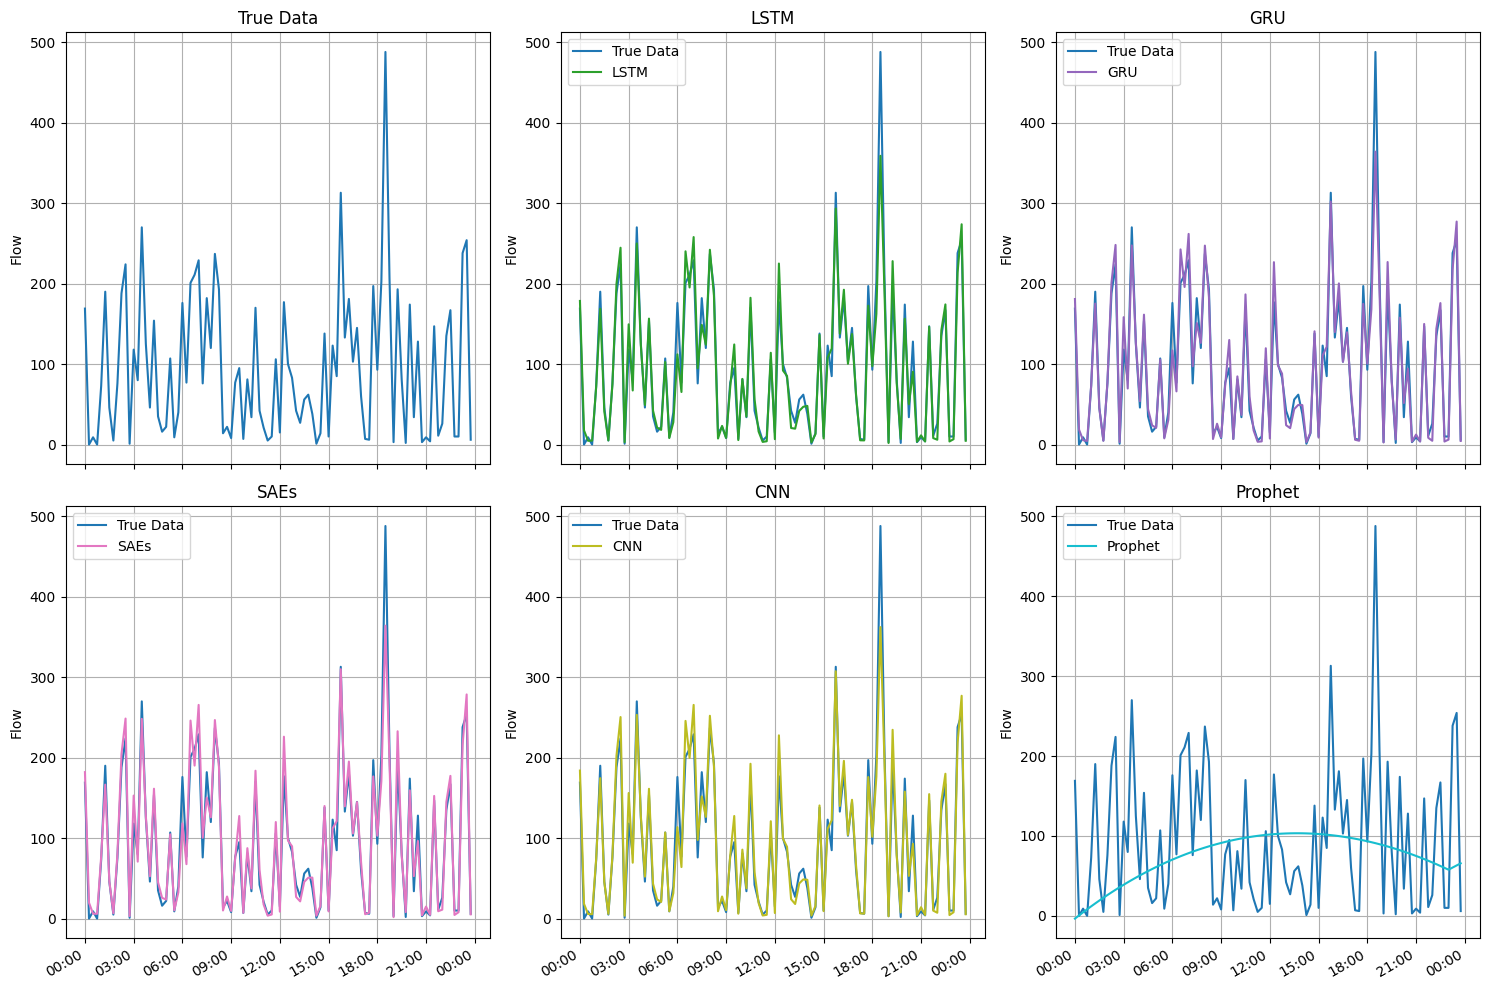

In [ ]:
plot_results(y_test[:periods * 7], y_preds, names, periods)

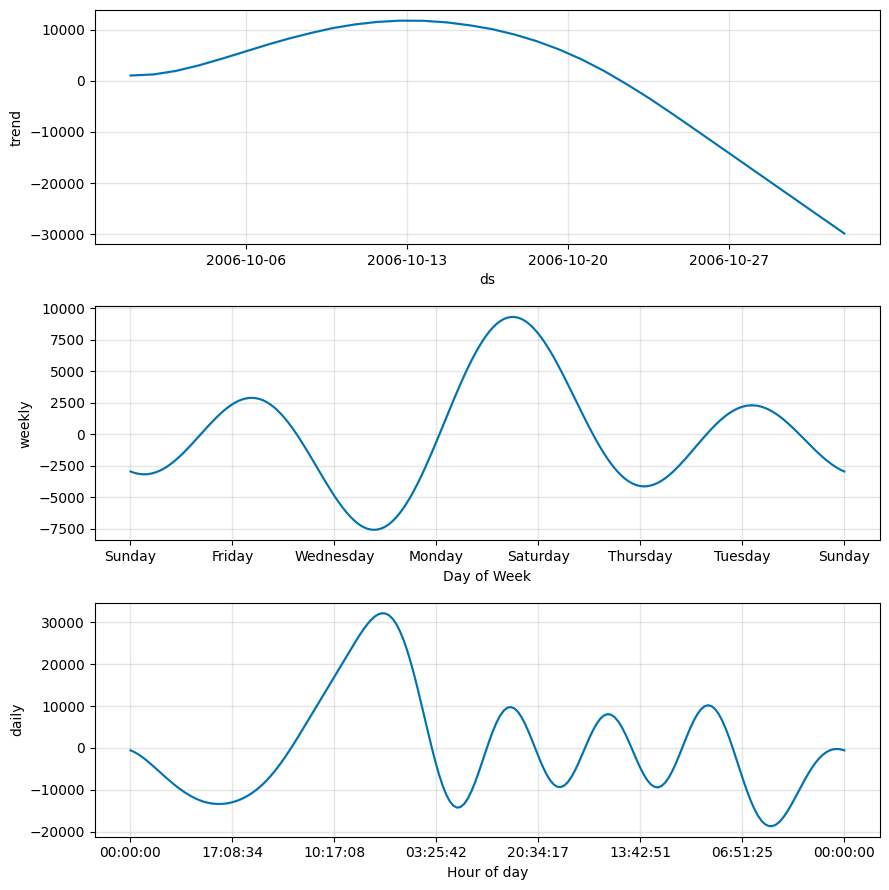

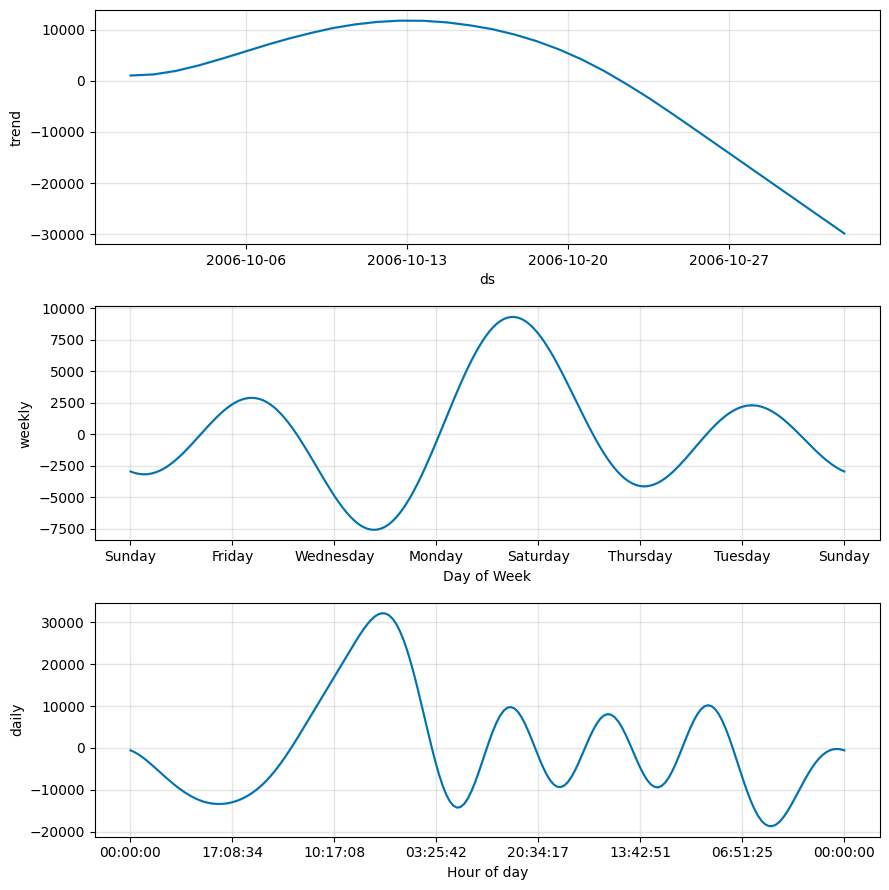

In [ ]:
prophet.plot_components(predicted)